In [20]:
#import required classes and packages
import os
import cv2
import numpy as np
from keras.layers import  MaxPooling2D
from keras.layers import Input, Conv2D, UpSampling2D
from keras.layers import Convolution2D
from keras.models import Sequential, load_model, Model
import pickle
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import keras
from sklearn.metrics import accuracy_score
from skimage import feature
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from PIL import Image
from math import log10, sqrt
from skimage.metrics import structural_similarity as ssim #function to calculate SSIM
import matplotlib.pyplot as plt

In [21]:
#function to calculate SSIM between original and decoded or compress image 
def imageSSIM(original, predict):
    original_image = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    predict_image = cv2.cvtColor(predict, cv2.COLOR_BGR2GRAY)
    ssim_value = ssim(original_image, predict_image, data_range = predict_image.max() - predict_image.min())
    return round(ssim_value, 3)

#function to calculate PSNR between original and  decoded or compress image 
def PSNR(original, predict):
    max_value = 255
    mse = np.mean((original - predict) ** 2) 
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_value / sqrt(mse)) 
    return psnr/100, mse

In [22]:
#global variable definition of dataset location and X, Y training array
path = "Dataset"
X = []
Y = []

In [23]:
#function to calculate OMLSVD from given image path
def getOmlsvd(path):
    image = Image.open(path).convert('L')
    image_array = np.array(image)
    #get SVD
    U, S, V = np.linalg.svd(image_array)
    S = np.diag(S)
    k = 50
    #calculate optimial values
    oml = U[:, :k] @ S[0:k,:k] @ V[:k, :]
    oml = Image.fromarray(oml.astype(np.uint8))
    oml.save('oml.jpg')
    oml = cv2.imread('oml.jpg')
    oml = cv2.resize(oml, (128, 128), cv2.INTER_LANCZOS4)
    return oml

In [5]:
#function to load all images from dataset folder and then create X and Y training array
if os.path.exists('model/X.npy'):#if OMLSVD already computed then load it
    X = np.load('model/X.npy')
    Y = np.load('model/Y.npy')
else:#if OMLSVD not computed then loop each image and then get OMLSVD features 
    X = []
    Y = []
    for root, dirs, directory in os.walk(path):
        for j in range(len(directory)):
            oml = getOmlsvd(root+"/"+directory[j]) #get oMLsvd from given image
            img = cv2.imread(root+"/"+directory[j])#get normal image for prediction
            img = cv2.resize(img, (128, 128), cv2.INTER_LANCZOS4)#resize image
            X.append(oml)#add ML features to X array as training compress array
            Y.append(img)#add normal image to predict as uncompress image
    X = np.asarray(X)
    Y = np.asarray(Y)
    np.save('model/X',X)
    np.save('model/Y',Y)
print("Dataset OMLSVD Features compression completed")
print("Total images found in dataset = "+str(X.shape[0]))

Dataset OMLSVD Features compression completed
Total images found in dataset = 568


In [6]:
#image preprocessing such as shuffling and normalization
X = X.astype('float32') #normalize images
X = X/255
Y = Y.astype('float32')
Y = Y/255
indices = np.arange(X.shape[0])
np.random.shuffle(indices) #shuffle images
X = X[indices]
Y = Y[indices]
print("Images preprocessing completed")

Images preprocessing completed


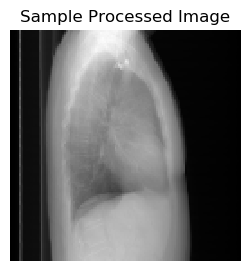

In [7]:
#display sample laoded and processed image
img = Y[0]
plt.figure(figsize=(4, 3))
plt.imshow(img)
plt.title("Sample Processed Image")
plt.axis('off')
plt.show()

In [8]:
#split images into train and test for encoder and decoder training
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) #split dataset into train and test
print("80% images used to train encoder algorithm : "+str(X_train.shape[0]))
print("20% images used to test encoder algorithm : "+str(X_test.shape[0]))

80% images used to train encoder algorithm : 454
20% images used to test encoder algorithm : 114


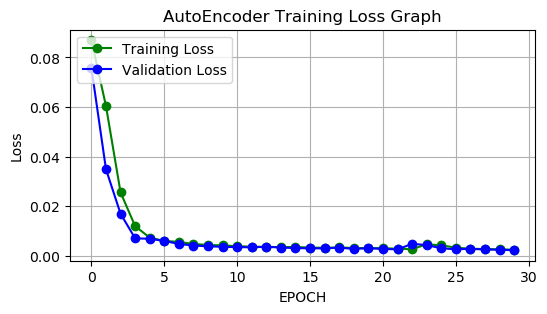

In [24]:
#train encoder and decoder algorithm on OMLSVD features
input_img = Input(shape=(128, 128, 3))
#defining encoder layer of 64 neurons with 3 X 3 matrix for features optimization
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
#decoder model to predict image for given compress image
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
decoder_model = Model(input_img, decoded)
#compile, train and load model
decoder_model.compile(optimizer='adam', loss='mean_squared_error')
if os.path.exists("model/decoder_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/decoder_weights.hdf5', verbose = 1, save_best_only = True)
    hist = decoder_model.fit(X_train, y_train, batch_size = 64, epochs = 30, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/decoder_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    decoder_model.load_weights("model/decoder_weights.hdf5")
f = open('model/decoder_history.pckl', 'rb')
train_values = pickle.load(f)
f.close()
plt.figure(figsize=(6, 3))
plt.grid(True)
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.plot(train_values['loss'], 'ro-', color = 'green')
plt.plot(train_values['val_loss'], 'ro-', color = 'blue')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.title('AutoEncoder Training Loss Graph')
plt.show()

In [10]:
#compress image using existing JPEG2000 and OMLSVD technique and then compute sizes
import pandas as pd
original_image = cv2.imread("Dataset/0001a_frontal.png")
compress_param = [int(cv2.IMWRITE_JPEG_QUALITY), 90]
cv2.imwrite('jpg_compress.jpg', original_image, compress_param)
original_size = os.path.getsize("Dataset/0001a_frontal.png")
jpg_compress_size = os.path.getsize("jpg_compress.jpg")
omlsvd_compress_size = getOmlsvd("Dataset/0001a_frontal.png")
omlsvd_compress_size = os.path.getsize("oml.jpg")
size = pd.DataFrame([[original_size, jpg_compress_size, omlsvd_compress_size]], columns=['Original Storage', 'JPEG Compression', 'OMLSVD Compression'])
size

,Original Storage,JPEG Compression,OMLSVD Compression
0,115318,30758,17295


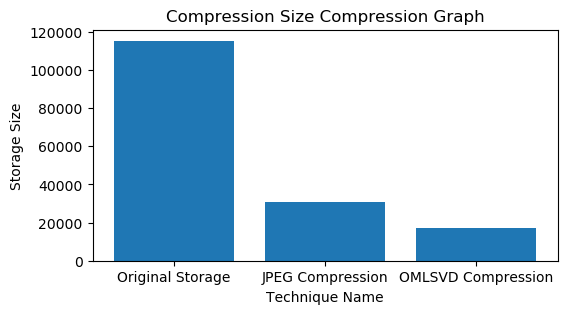

In [11]:
#storage size comparison graph
height = [original_size, jpg_compress_size, omlsvd_compress_size]
bars = ['Original Storage', 'JPEG Compression', 'OMLSVD Compression']
y_pos = np.arange(len(bars))
plt.figure(figsize = (6, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Technique Name")
plt.ylabel("Storage Size")
plt.title("Compression Size Compression Graph")
plt.show()

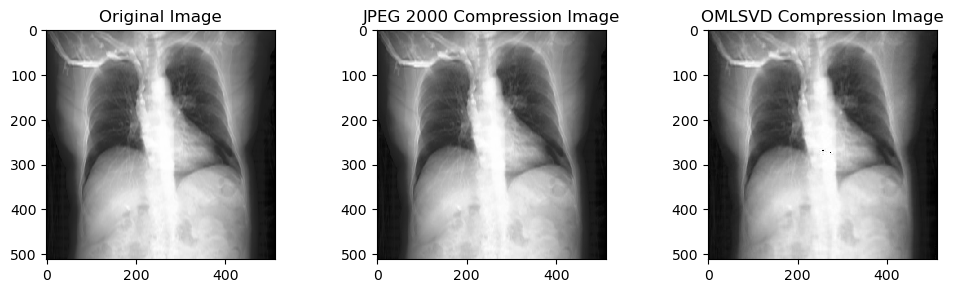

In [12]:
#visualizing original, jpeg compression and OMLSVD compression image
figure, axis = plt.subplots(nrows=1, ncols=3,figsize=(10,3))
axis[0].set_title("Original Image")
axis[1].set_title("JPEG 2000 Compression Image")
axis[2].set_title("OMLSVD Compression Image")
axis[0].imshow(original_image)
axis[1].imshow(cv2.imread("jpg_compress.jpg"))
axis[2].imshow(cv2.imread("oml.jpg"))
figure.tight_layout()
plt.show()           

In [13]:
#update autoencoder model weights to federated server
import requests
import Privacy
import json
autoencoder_weight = decoder_model.get_weights()#get weights of encoder model
autoencoder_weight = json.dumps(autoencoder_weight, cls=Privacy.Privacy)#convert weight to json with privacy
requests.put('http://127.0.0.1:8000/update', data=autoencoder_weight)#send weight to given URL federated server
print("AutoEncoder weights sent to Federated Server")

AutoEncoder weights sent to Federated Server


In [14]:
#now get weights from federated server to form global model
result = requests.get('http://127.0.0.1:8000/weight')#get weights from federated server
result_data = result.json()
global_weight = None
if result_data is not None:
    global_weight = []
    for i in range(len(result_data)):#loop all clients weights and append to global weight
        temp = np.array(result_data[i])
        global_weight.append(temp)
    global_weight = np.asarray(global_weight)
decoder_model.set_weights(global_weight)    
print("Weights successfully obtained from Federated Server")

Weights successfully obtained from Federated Server


In [15]:
#function to decompress image using encoder model and then calculate SSIM and PSNR
def decodeCompressImage(path):
    original = cv2.imread(path) #reading original image
    original = cv2.resize(original, (128, 128), cv2.INTER_LANCZOS4)
    test = getOmlsvd(path)#compressing original image using OMLSVD
    temp = []
    temp.append(test)
    test = np.asarray(temp)
    test = test.astype('float32')
    test = test/255
    predict = decoder_model.predict(test)#applying global autoencoder model to decompress image
    predict = predict[0]#get predicted decompress image
    ssim_value = imageSSIM(original, predict*255)#calculate SSIM
    psnr, mse = PSNR(original, predict*255)#calculatee PSNR
    print("PSNR = "+str(psnr))
    print("SSIM - "+str(ssim_value))
    figure, axis = plt.subplots(nrows=1, ncols=2,figsize=(6,3))#visualize images
    axis[0].set_title("Original Image")
    axis[1].set_title("AutoEncoder Decompressed Image")
    axis[0].imshow(original)
    axis[1].imshow(predict)
    figure.tight_layout()
    plt.show()  


PSNR = 0.25290413877692147
SSIM - 0.752


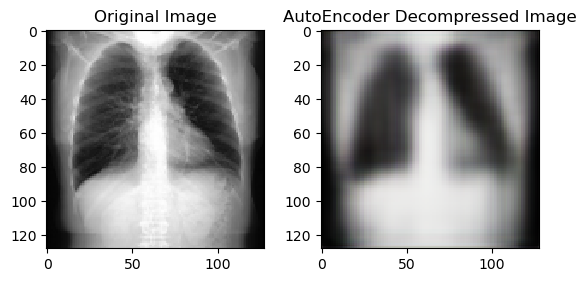

In [16]:
#call function to decompress given test image and then calculate PSNR and SSIM
decodeCompressImage("testImages/1.png")

PSNR = 0.2885806128514157
SSIM - 0.771


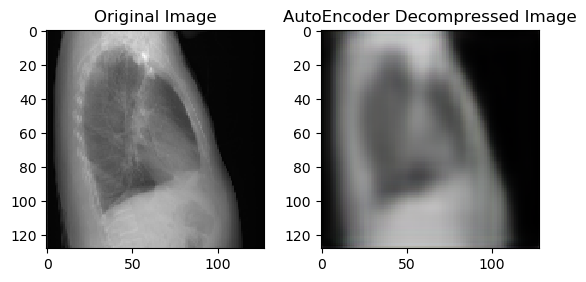

In [17]:
#call function to decompress given test image and then calculate PSNR and SSIM
decodeCompressImage("testImages/2.png")

PSNR = 0.2565456958626607
SSIM - 0.774


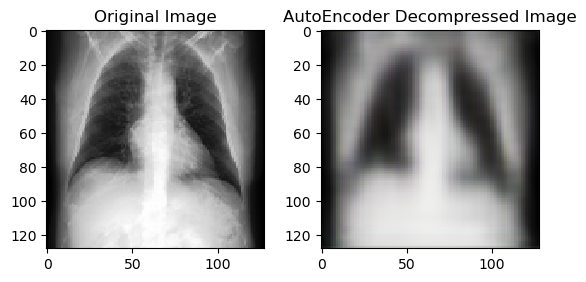

In [18]:
#call function to decompress given test image and then calculate PSNR and SSIM
decodeCompressImage("testImages/6.png")

PSNR = 0.26533655764398817
SSIM - 0.753


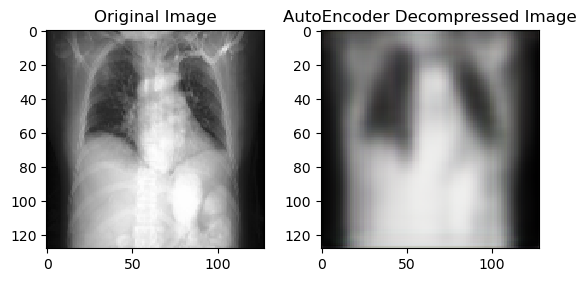

In [19]:
#call function to decompress given test image and then calculate PSNR and SSIM
decodeCompressImage("testImages/7.png")